<div style="text-align:center;"><img style="width: 30%;" src="static/Logo_course.png"></div>

    

Ing. Paul Muñoz, PhD.

paul.andres.munoz@gmail.com  ;  paul.munozp@ucuenca.edu.ec
    
    

# Taller 4: Desarrollo de modelos de pronóstico hidrológico.

En esta sesión vamos a:
    - Desarrollar modelos de pronóstico para la cuenca del río Tomebamba.

## Importar librerías

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as dates
import os
import datetime
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from copy import deepcopy
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import itertools

def lagged_dataset(arr, num_steps, additional_arr, new_num_steps):
    num_columns = arr.shape[1]
    modified_rows = []
    excluded_data = []
    for i in range(num_steps, arr.shape[0]):
        prev_rows = arr[i - num_steps:i]
        current_row = arr[i]
        new_row = np.concatenate((prev_rows.flatten(), current_row))
        modified_rows.append(new_row)
    result_array = np.array(modified_rows)
    # Slicing the result_array to match the number of rows in modified_additional_arr
    if result_array.shape[0] > additional_arr.shape[0]:
        result_array = result_array[result_array.shape[0] - additional_arr.shape[0]:]

    modified_rows = []
    for i in range(new_num_steps, additional_arr.shape[0]):
        prev_rows = additional_arr[i - new_num_steps:i]
        current_row = additional_arr[i]
        excluded_data.append(current_row[-1])  # Store excluded data
        new_row = np.concatenate((prev_rows.flatten(), current_row[:-1]))  # Exclude last column
        modified_rows.append(new_row)

    modified_additional_arr = np.array(modified_rows)

    # Adjust dimensions by removing rows from result_array or modified_additional_arr
    min_rows = min(result_array.shape[0], modified_additional_arr.shape[0])
    result_array = result_array[-min_rows:]
    modified_additional_arr = modified_additional_arr[-min_rows:]
    excluded_data = np.array(excluded_data)[-min_rows:]

    # Concatenate result_array and modified_additional_arr
    final_result = np.concatenate((result_array, modified_additional_arr), axis=1)

    return final_result, np.array(excluded_data)[:, None]

def lagged_dataset_pron(arr, num_steps, additional_arr, new_num_steps, lead_time):
    num_columns = arr.shape[1]
    modified_rows = []
    excluded_data = []

    for i in range(num_steps, arr.shape[0]):
        prev_rows = arr[i - num_steps:i]
        current_row = arr[i]
        new_row = np.concatenate((prev_rows.flatten(), current_row))
        modified_rows.append(new_row)

    result_array = np.array(modified_rows)

    # Slicing the result_array to match the number of rows in modified_additional_arr
    if result_array.shape[0] > additional_arr.shape[0]:
        result_array = result_array[result_array.shape[0] - additional_arr.shape[0]:]

    modified_rows = []
    for i in range(new_num_steps, additional_arr.shape[0]):
        prev_rows = additional_arr[i - new_num_steps:i]
        current_row = additional_arr[i]
        excluded_data.append(current_row[-1])  # Store excluded data
        new_row = np.concatenate((prev_rows.flatten(), current_row))  # Include last column
        modified_rows.append(new_row)

    modified_additional_arr = np.array(modified_rows)

    # Adjust dimensions by removing rows from result_array or modified_additional_arr
    min_rows = min(result_array.shape[0], modified_additional_arr.shape[0])
    result_array = result_array[-min_rows:]
    modified_additional_arr = modified_additional_arr[-min_rows:]
    excluded_data = np.array(excluded_data)[-min_rows:]

    # Shift excluded_data by lead_time
    excluded_data = excluded_data[lead_time:]

    # Concatenate result_array and modified_additional_arr
    final_result = np.concatenate((result_array, modified_additional_arr), axis=1)

    # Resize final_result and excluded_data to have the same number of rows
    min_rows = min(final_result.shape[0], excluded_data.shape[0])
    final_result = final_result[:min_rows]
    excluded_data = excluded_data[:min_rows]

    return final_result, np.array(excluded_data)[:, None]


def calculate_hydro_metrics(simulations, evaluation):
    sim_mean = np.mean(simulations, axis=0, dtype=np.float64)
    obs_mean = np.mean(evaluation, dtype=np.float64)

    r_num = np.sum((simulations - sim_mean) * (evaluation - obs_mean),
                   axis=0, dtype=np.float64)
    r_den = np.sqrt(np.sum((simulations - sim_mean) ** 2,
                           axis=0, dtype=np.float64)
                    * np.sum((evaluation - obs_mean) ** 2,
                             dtype=np.float64))
    r = r_num / r_den
    # calculate error in spread of flow alpha
    alpha = np.std(simulations, axis=0) / np.std(evaluation, dtype=np.float64)
    # calculate error in volume beta (bias of mean discharge)
    beta = (np.sum(simulations, axis=0, dtype=np.float64)
            / np.sum(evaluation, dtype=np.float64))
    # calculate the Kling-Gupta Efficiency KGE
    kge = 1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)
    rmse = np.sqrt(np.mean((evaluation - simulations) ** 2,
                            axis=0, dtype=np.float64))
    pbias = (100 * np.sum(evaluation - simulations, axis=0, dtype=np.float64)
              / np.sum(evaluation))
    r2 = 1 - (np.sum((evaluation - simulations)**2) / np.sum((evaluation - np.mean(evaluation))**2))
    return kge, rmse, pbias, r2
np.random.seed(22)
import random
random.seed(22)

## Seleccionar carpeta del proyecto

In [2]:
folder = os.getcwd()+'/data/'
folder

'/Users/paul/Documents/PNUD/Clases/3_Miércoles_18_octubre/data/'

## Importar datos de precipitación

### Precipitación satelital

Leer datos de la cuenca del río Tomebamba

In [5]:
precipitation_satellite= pd.read_table(folder+'PERSIANN-CCS_UTC_daily_tomebamba_full.csv', sep=',')
precipitation_satellite.rename(columns={'Unnamed: 0':'Date'},inplace=True)
precipitation_satellite['Date'] = precipitation_satellite.Date.apply(lambda x: pd.to_datetime(x,dayfirst=True))
precipitation_satellite.set_index(precipitation_satellite['Date'],inplace=True)
precipitation_satellite = precipitation_satellite.drop('Date',1)


/Users/paul/opt/anaconda3/envs/INAMHI_forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


In [6]:
precipitation_satellite

,1,2,3,6,7,8,9,10,12,13,...,21,22,23,24,25,26,27,28,31,32
Date,,,,,,,,,,,,,,,,,,,,,
2003-01-01,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0
2003-01-02,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0
2003-01-03,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0
2003-01-04,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0
2003-01-05,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-09,0.0,0.2,0.48,0.0,0.0,0.0,0.2,0.0,0.0,0.0,...,1.2,0.0,0.0,1.41,0.5,0.0,1.22,5.22,2.12,0.5
2023-08-10,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0
2023-08-11,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0


Calcular la precipitación anual

In [7]:
data_annual = precipitation_satellite.resample('Y',label='right',closed='right').sum()

Graficar precipitación promedio anual

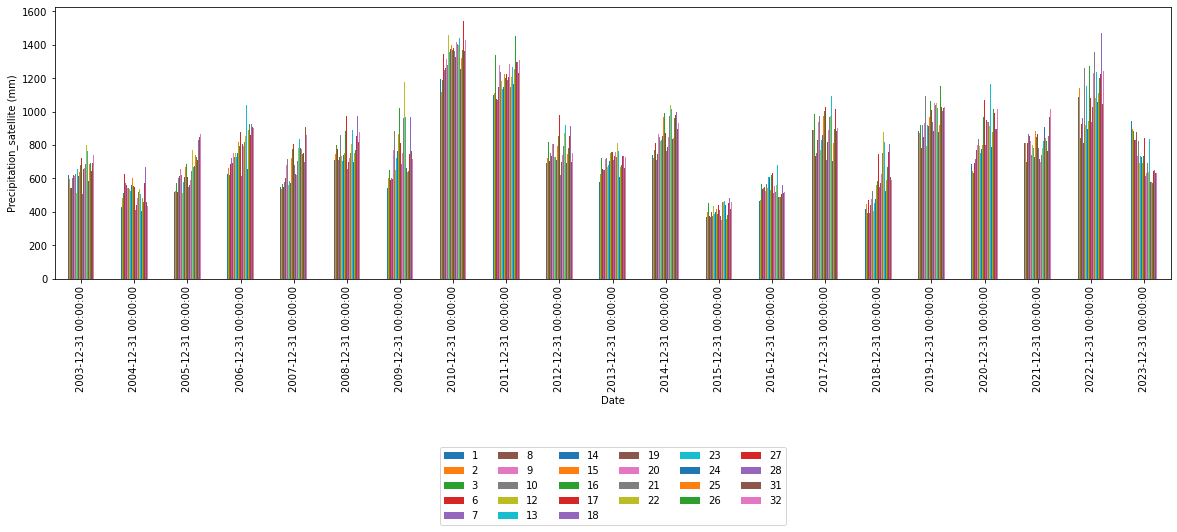

In [8]:
fig, ax = plt.subplots(figsize=(20,5))
# Assuming dataset is a pandas DataFrame with labeled columns
data_annual.plot(kind='bar', ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Precipitation_satellite (mm)')
# Adjusting the position of the legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=6)
plt.show()

Calcular precipitación anual promedio de todos los pixeles de la cuenca

In [9]:
data_annual_average =  data_annual.mean(axis=1)
data_annual_average

Date
2003-12-31     646.573704
2004-12-31     518.426667
2005-12-31     647.289630
2006-12-31     785.916296
2007-12-31     688.204074
2008-12-31     783.095185
2009-12-31     757.777407
2010-12-31    1350.764074
2011-12-31    1214.637037
2012-12-31     774.968518
2013-12-31     703.155185
2014-12-31     867.641481
2015-12-31     411.308889
2016-12-31     546.482593
2017-12-31     896.134815
2018-12-31     575.480741
2019-12-31     961.138519
2020-12-31     856.483704
2021-12-31     816.882222
2022-12-31    1086.663333
2023-12-31     725.140741
Freq: A-DEC, dtype: float64

Graficar la precipitación promedio (todos los pixeles)

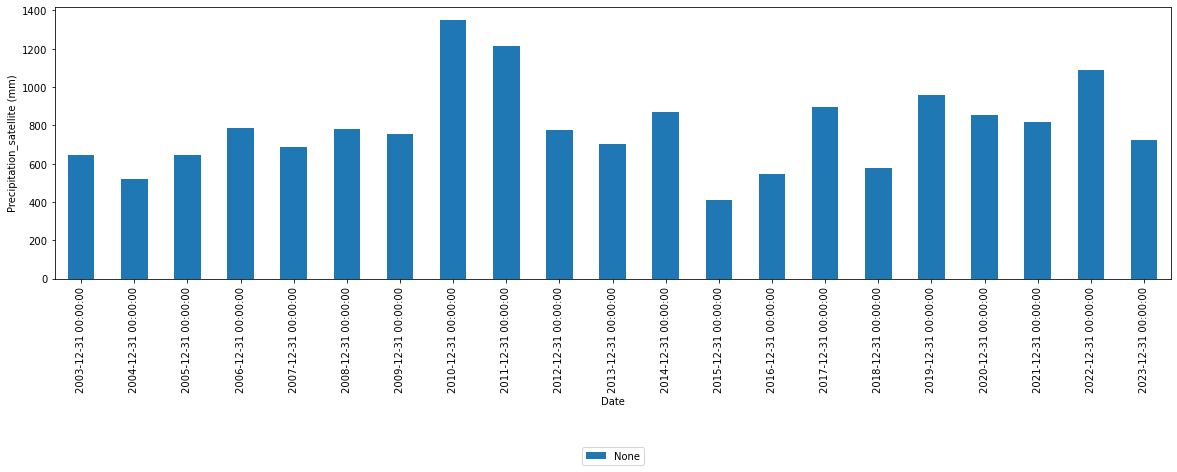

In [10]:
fig, ax = plt.subplots(figsize=(20,5))
# Assuming dataset is a pandas DataFrame with labeled columns
data_annual_average.plot(kind='bar', ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Precipitation_satellite (mm)')
# Adjusting the position of the legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=6)
plt.show()

Calcular la precipitación anual promedio en la cuenca

In [11]:
data_annual_average.mean()

791.1507054652681

Calcular la precipitación mensual


In [12]:
data_monthly = precipitation_satellite.resample('M',label='right',closed='right').sum() 
data_monthly

,1,2,3,6,7,8,9,10,12,13,...,21,22,23,24,25,26,27,28,31,32
Date,,,,,,,,,,,,,,,,,,,,,
2003-01-31,18.53,23.37,29.94,22.73,39.06,42.16,40.16,39.92,29.47,40.56,...,45.47,53.39,56.34,33.75,41.68,56.50,51.82,43.20,48.60,52.30
2003-02-28,75.35,76.53,40.15,41.76,50.23,51.24,51.58,51.47,39.63,40.90,...,55.21,46.67,38.47,29.85,33.75,36.01,54.97,42.35,41.17,49.25
2003-03-31,33.84,33.78,61.99,33.31,32.94,43.43,47.93,47.92,35.19,38.17,...,127.65,113.41,85.31,39.25,58.83,69.97,100.33,111.59,65.35,85.21
2003-04-30,67.83,39.61,36.54,116.87,111.30,71.06,55.90,97.56,57.83,77.65,...,96.13,138.09,81.70,70.13,94.21,92.85,60.37,117.50,90.72,143.74
2003-05-31,1.64,1.03,1.03,1.46,2.47,3.91,3.65,1.57,3.52,5.11,...,1.94,2.21,33.88,0.00,1.18,1.96,2.32,7.70,1.22,2.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-30,282.20,300.62,318.64,317.19,328.45,308.91,289.28,270.67,312.74,321.06,...,272.43,255.13,300.12,279.92,244.27,247.67,285.49,250.60,245.79,238.41
2023-05-31,142.07,110.56,74.78,81.62,63.36,58.01,59.44,68.27,83.39,50.48,...,56.28,57.32,96.61,35.55,47.45,43.04,43.20,41.47,44.51,54.98
2023-06-30,13.84,8.62,7.92,7.50,8.57,13.41,7.89,7.35,5.23,5.58,...,4.95,9.65,3.56,4.03,2.21,4.31,9.20,5.95,6.88,21.07


Calcular precipitación promedio mensual de todos los pixeles de la cuenca

In [14]:
data_monthly_mean_pixels =  data_monthly.mean(axis=1)
data_monthly_mean_pixels

Date
2003-01-31     40.502593
2003-02-28     45.911111
2003-03-31     60.481111
2003-04-30     84.432963
2003-05-31      3.860370
                 ...    
2023-04-30    283.854074
2023-05-31     64.770370
2023-06-30      7.100000
2023-07-31     13.341111
2023-08-31      0.501852
Freq: M, Length: 248, dtype: float64

Graficar

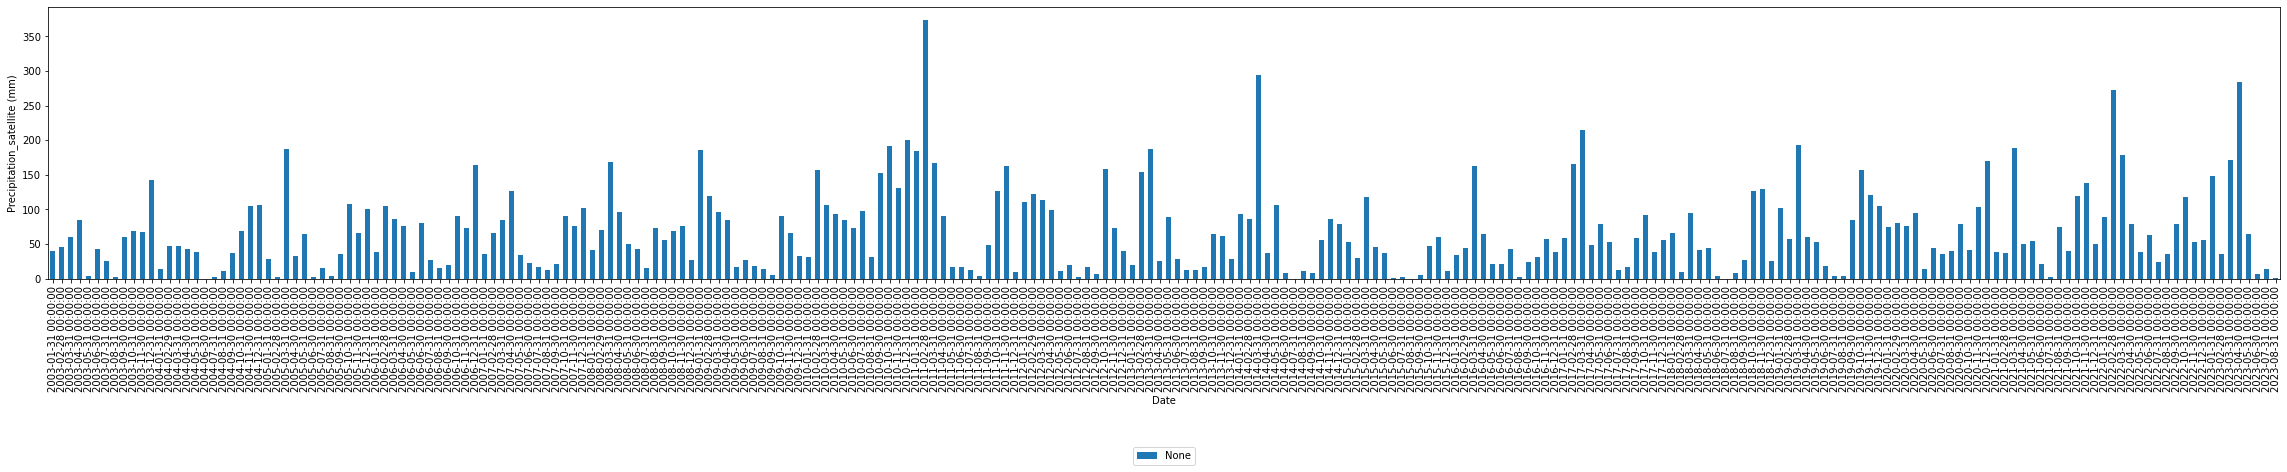

In [15]:
fig, ax = plt.subplots(figsize=(40,5))
# Assuming dataset is a pandas DataFrame with labeled columns
data_monthly_mean_pixels.plot(kind='bar', ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Precipitation_satellite (mm)')
# Adjusting the position of the legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=6)
plt.show()

Calcular precipitación promedio mensual (promedio de todos los pixeles de la cuenca)

In [16]:
data_monthly_mean= data_monthly_mean_pixels.groupby(data_monthly_mean_pixels.index.month).mean()
data_monthly_mean

Date
1      70.852099
2      99.124885
3     142.750617
4      78.946543
5      44.431270
6      28.550265
7      18.388448
8      18.638889
9      43.499741
10     95.832000
11     87.352870
12     77.256463
dtype: float64

Graficar

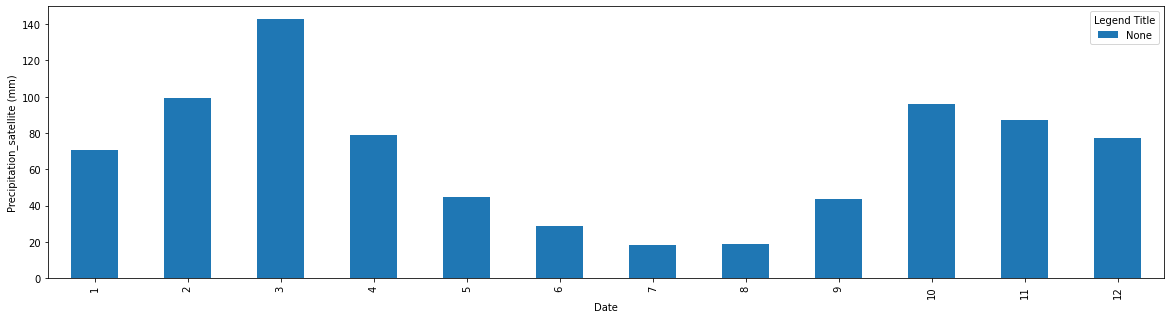

In [17]:
fig, ax = plt.subplots(figsize=(20,5))
# Assuming dataset is a pandas DataFrame with labeled columns
data_monthly_mean.plot(kind='bar', ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Precipitation_satellite (mm)')
plt.show()

### Importar precipitación in-situ

Disponemos de tres pluviómetros instalados dentro de la cuenca

#### Para el pluviómetro 1


Importar y preprocesar los datos

In [18]:
folder_pcp_1 = folder+'Pluviómetro_1/'
df_pcp_1= pd.read_table(folder_pcp_1+'Pluviómetro_1.csv', sep=',')
df_pcp_1.rename(columns={'Texas_tip_corrected_mm':'Pluviómetro_1'},inplace=True)
df_pcp_1.columns
df_pcp_1

,Date_yy/mm/dd_hh:mm:ss,Pluviómetro_1
0,2012-10-02 12:00:00,NaN
1,2012-10-02 13:00:00,0.0
2,2012-10-02 14:00:00,0.0
3,2012-10-02 15:00:00,0.0
4,2012-10-02 16:00:00,0.0
...,...,...
95638,2023-08-31 10:00:00,0.0
95639,2023-08-31 11:00:00,0.0
95640,2023-08-31 12:00:00,0.0
95641,2023-08-31 13:00:00,0.0


Operaciones para ordenar la información en un dataframe manejable

In [19]:
df_pcp_1.rename(columns={'Date_yy/mm/dd_hh:mm:ss':'Date'},inplace=True)
df_pcp_1['Date'] = df_pcp_1.Date.apply(lambda x: pd.to_datetime(x,dayfirst=True))
df_pcp_1.set_index(df_pcp_1['Date'],inplace=True)
df_pcp_1 = df_pcp_1.drop('Date',1)
df_pcp_1

/Users/paul/opt/anaconda3/envs/INAMHI_forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


,Pluviómetro_1
Date,
2012-10-02 12:00:00,NaN
2012-10-02 13:00:00,0.0
2012-10-02 14:00:00,0.0
2012-10-02 15:00:00,0.0
2012-10-02 16:00:00,0.0
...,...
2023-08-31 10:00:00,0.0
2023-08-31 11:00:00,0.0
2023-08-31 12:00:00,0.0


Graficar el año 2020 de la serie de precipitación importada

/Users/paul/opt/anaconda3/envs/INAMHI_forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


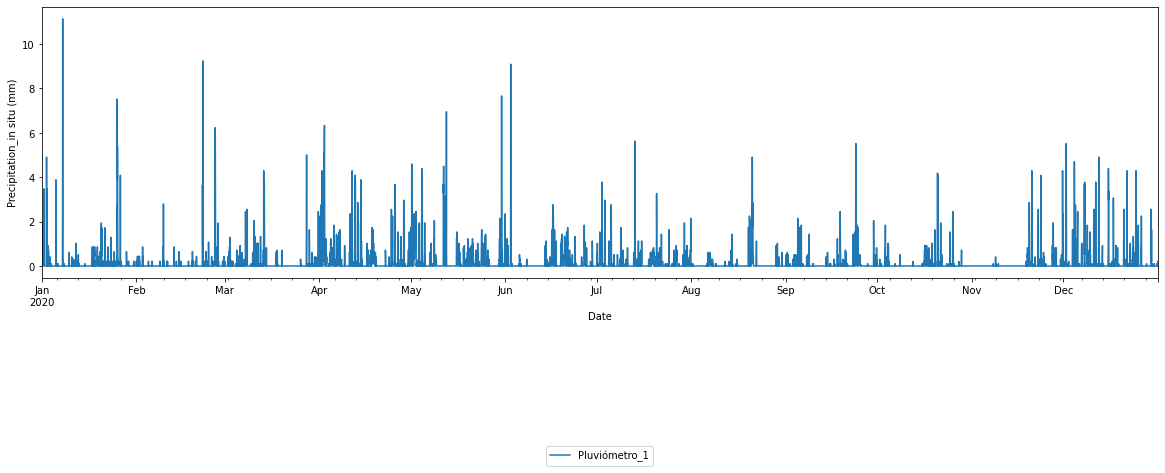

In [20]:
fig, ax = plt.subplots(figsize=(20,5))
# Assuming dataset is a pandas DataFrame with labeled columns
df_pcp_1['2020'].plot(ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Precipitation_in situ (mm)')
# Adjusting the position of the legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=6)
plt.show()

Graficar la precipitación acumulada del 2020 de la serie temporal importada

/Users/paul/opt/anaconda3/envs/INAMHI_forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


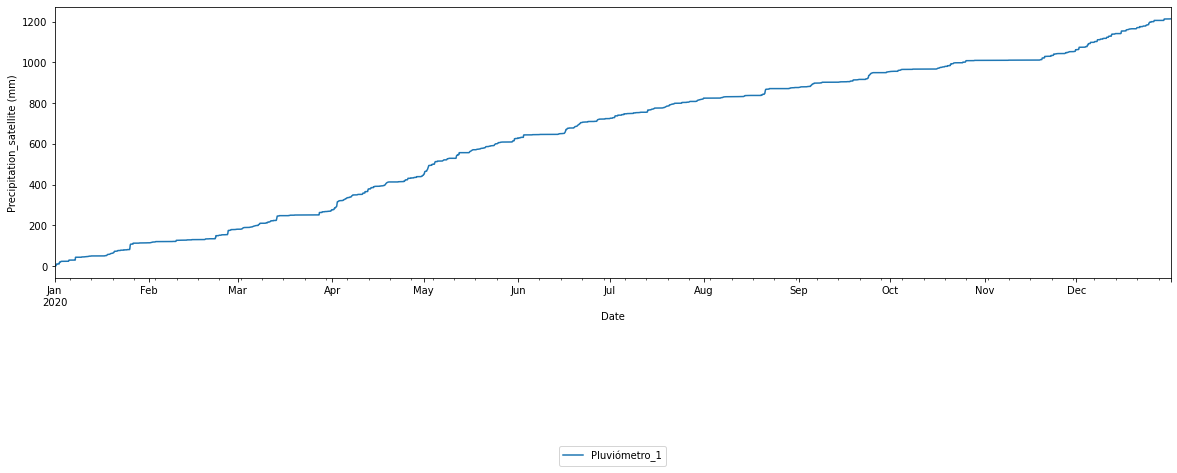

In [21]:
fig, ax = plt.subplots(figsize=(20,5))
# Assuming dataset is a pandas DataFrame with labeled columns
df_pcp_1['2020'].cumsum().plot(ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Precipitation_satellite (mm)')
# Adjusting the position of the legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=6)
plt.show()

#### Para el pluviómetro 2


Importar y preprocesar los datos

In [22]:
folder_pcp_2 = folder+'Pluviómetro_2/'
df_pcp_2= pd.read_table(folder_pcp_2+'Pluviómetro_2.csv', sep=',')
df_pcp_2

,Date,Precipitation
0,2013-03-07 17:00:00,0.000000
1,2013-03-07 18:00:00,0.000000
2,2013-03-07 19:00:00,0.000000
3,2013-03-07 20:00:00,0.000000
4,2013-03-07 21:00:00,0.000000
...,...,...
94125,2023-12-02 14:00:00,0.000000
94126,2023-12-02 15:00:00,0.000000
94127,2023-12-02 16:00:00,0.000000
94128,2023-12-02 17:00:00,0.000000


Operaciones para crear un dataframe manejable

In [23]:
df_pcp_2['Date'] = df_pcp_2.Date.apply(lambda x: pd.to_datetime(x,dayfirst=True))
df_pcp_2.set_index(df_pcp_2['Date'],inplace=True)
df_pcp_2 = df_pcp_2.drop('Date',1)
df_pcp_2.rename(columns={'Precipitation':'Pluviómetro_2'},inplace=True)
df_pcp_2

/Users/paul/opt/anaconda3/envs/INAMHI_forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,Pluviómetro_2
Date,
2013-03-07 17:00:00,0.000000
2013-03-07 18:00:00,0.000000
2013-03-07 19:00:00,0.000000
2013-03-07 20:00:00,0.000000
2013-03-07 21:00:00,0.000000
...,...
2023-12-02 14:00:00,0.000000
2023-12-02 15:00:00,0.000000
2023-12-02 16:00:00,0.000000


Graficar el año 2020 de la serie importada

/Users/paul/opt/anaconda3/envs/INAMHI_forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


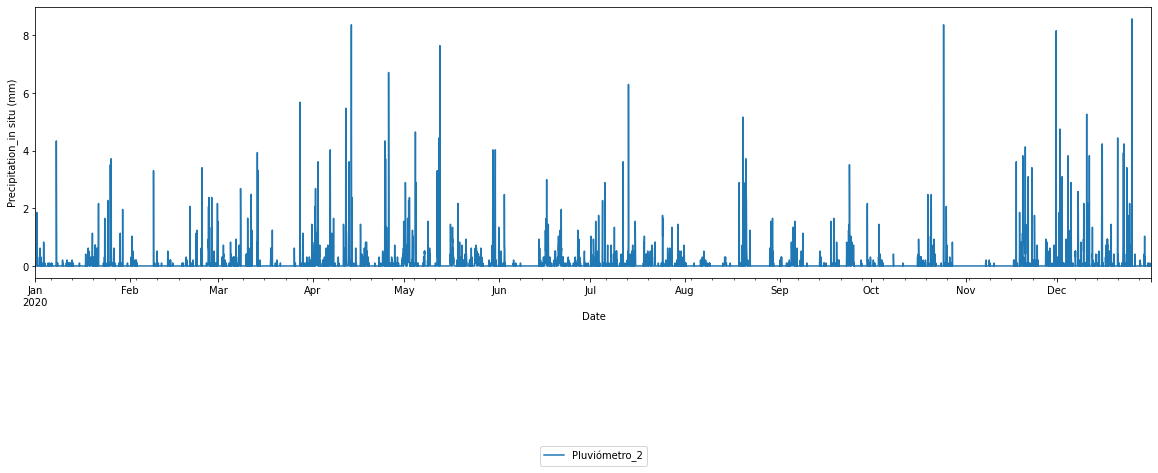

In [24]:
fig, ax = plt.subplots(figsize=(20,5))
# Assuming dataset is a pandas DataFrame with labeled columns
df_pcp_2['2020'].plot(ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Precipitation_in situ (mm)')
# Adjusting the position of the legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=6)
plt.show()

Graficar la precipitacióm acumulada del año 2020 de la serie importada

/Users/paul/opt/anaconda3/envs/INAMHI_forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


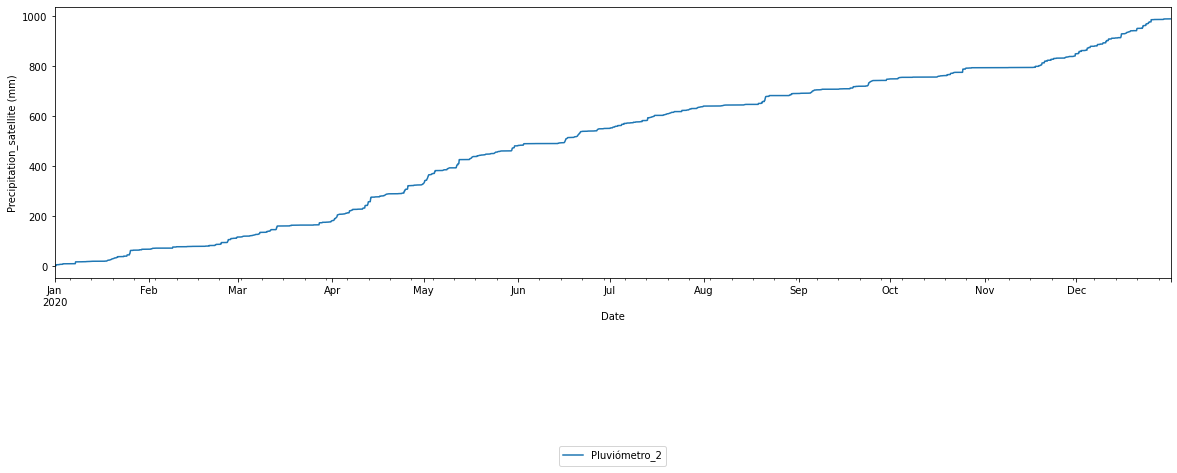

In [25]:
fig, ax = plt.subplots(figsize=(20,5))
# Assuming dataset is a pandas DataFrame with labeled columns
df_pcp_2['2020'].cumsum().plot(ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Precipitation_satellite (mm)')
# Adjusting the position of the legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=6)
plt.show()

#### Para el pluviómetro 3


Importar y preprocesar los datos

In [26]:
folder_pcp_3 = folder+'Pluviómetro_3/'
df_pcp_3= pd.read_table(folder_pcp_3+'Pluviómetro_3.csv', sep=',')
df_pcp_3

,Fecha,Precipitation
0,2012-09-27 12:00:00,0.108980
1,2012-09-27 13:00:00,4.904100
2,2012-09-27 14:00:00,2.724500
3,2012-09-27 15:00:00,2.179600
4,2012-09-27 16:00:00,0.544900
...,...,...
97994,2023-12-02 14:00:00,0.000000
97995,2023-12-02 15:00:00,0.245533
97996,2023-12-02 16:00:00,0.000000
97997,2023-12-02 17:00:00,0.000000


Operaciones para crear un dataframe manejable

In [27]:
df_pcp_3['Fecha'] = df_pcp_3.Fecha.apply(lambda x: pd.to_datetime(x,dayfirst=True))
df_pcp_3.set_index(df_pcp_3['Fecha'],inplace=True)
df_pcp_3 = df_pcp_3.drop('Fecha',1)
df_pcp_3.rename(columns={'Precipitation':'Pluviómetro_3'},inplace=True)
df_pcp_3

/Users/paul/opt/anaconda3/envs/INAMHI_forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,Pluviómetro_3
Fecha,
2012-09-27 12:00:00,0.108980
2012-09-27 13:00:00,4.904100
2012-09-27 14:00:00,2.724500
2012-09-27 15:00:00,2.179600
2012-09-27 16:00:00,0.544900
...,...
2023-12-02 14:00:00,0.000000
2023-12-02 15:00:00,0.245533
2023-12-02 16:00:00,0.000000


Graficar la precipitación del año 2020

/Users/paul/opt/anaconda3/envs/INAMHI_forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


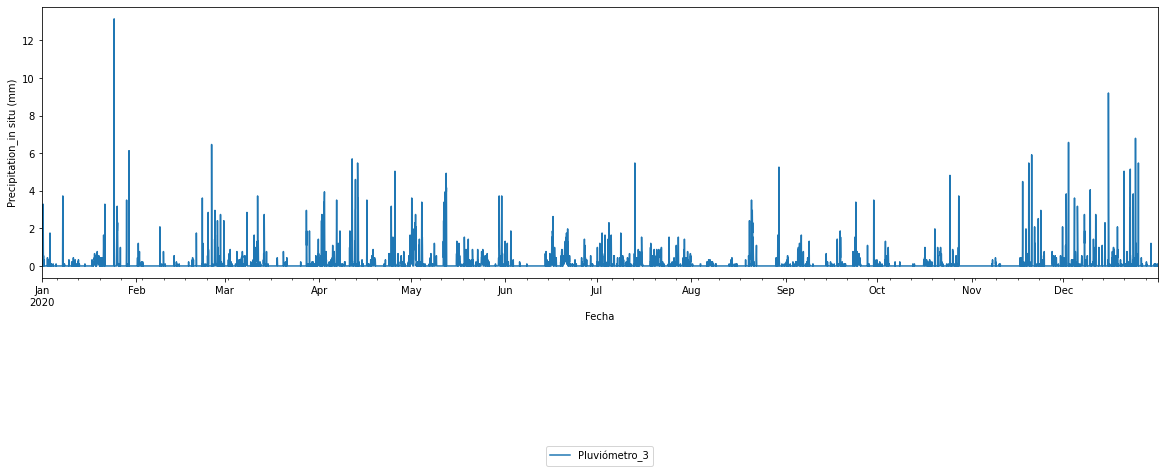

In [28]:
fig, ax = plt.subplots(figsize=(20,5))
# Assuming dataset is a pandas DataFrame with labeled columns
df_pcp_3['2020'].plot(ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Precipitation_in situ (mm)')
# Adjusting the position of the legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=6)
plt.show()

Graficar la precipitación acumulada del año 2020

/Users/paul/opt/anaconda3/envs/INAMHI_forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


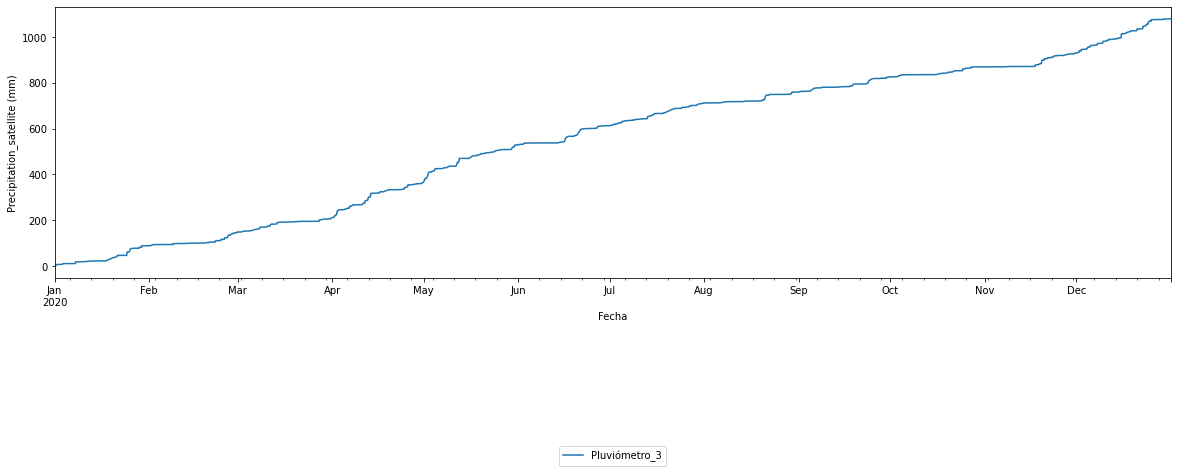

In [29]:
fig, ax = plt.subplots(figsize=(20,5))
# Assuming dataset is a pandas DataFrame with labeled columns
df_pcp_3['2020'].cumsum().plot(ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Precipitation_satellite (mm)')
# Adjusting the position of the legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=6)
plt.show()

#### Comparar la precipitación in-situ

Remuestrear la información de los 3 pluviómetros a escalas mensuales

In [30]:
df_pcp_1_monthly = df_pcp_1.resample('M',label='right',closed='right').sum() 
df_pcp_1_monthly= df_pcp_1_monthly.groupby(df_pcp_1_monthly.index.month).mean()
df_pcp_2_monthly = df_pcp_2.resample('M',label='right',closed='right').sum() 
df_pcp_2_monthly= df_pcp_2_monthly.groupby(df_pcp_2_monthly.index.month).mean()
df_pcp_3_monthly = df_pcp_3.resample('M',label='right',closed='right').sum() 
df_pcp_3_monthly= df_pcp_3_monthly.groupby(df_pcp_3_monthly.index.month).mean()
all_pcp_monthly = pd.concat([df_pcp_1_monthly, df_pcp_2_monthly, df_pcp_3_monthly], axis=1)

Graficar

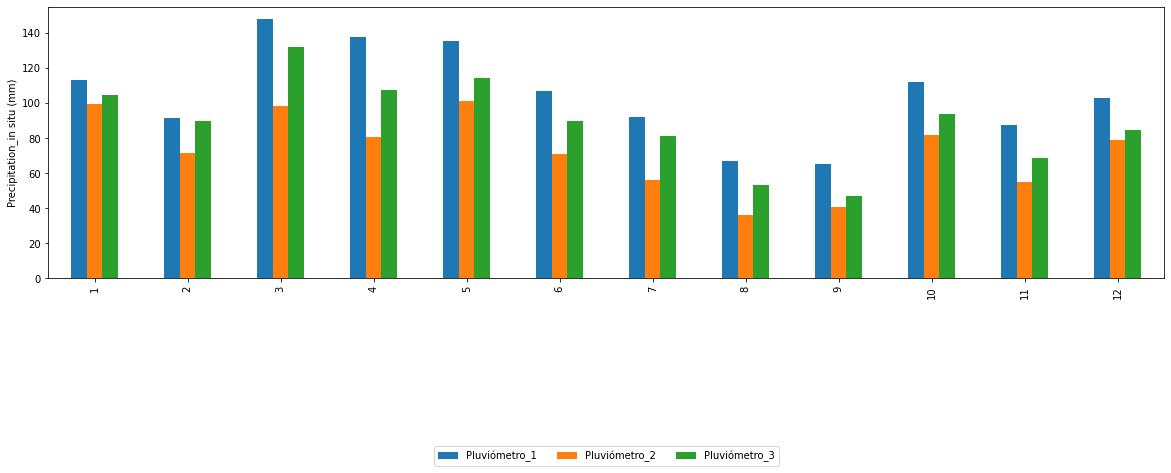

In [31]:
fig, ax = plt.subplots(figsize=(20,5))
# Assuming dataset is a pandas DataFrame with labeled columns
all_pcp_monthly.plot(kind='bar',ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Precipitation_in situ (mm)')
# Adjusting the position of the legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=6)
plt.show()

## Importar datos de caudal

Importar y organizar los datos caudal en un dataframe manejable

In [32]:
folder_caudal = folder+'Caudal_Tomebamba/'
df_caudal =  pd.read_excel(folder_caudal+'Tomebamba.xlsx')
df_caudal['Fecha'] = df_caudal.Fecha.apply(lambda x: pd.to_datetime(x,dayfirst=True))
df_caudal.set_index(df_caudal['Fecha'],inplace=True)
df_caudal = df_caudal.drop('Fecha',1)
df_caudal

/Users/paul/opt/anaconda3/envs/INAMHI_forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


,Caudal (m3/s)
Fecha,
1997-07-17 20:00:00,5.756145
1997-07-17 21:00:00,5.756145
1997-07-17 22:00:00,5.756145
1997-07-17 23:00:00,5.977188
1997-07-18 00:00:00,5.756145
...,...
2021-07-05 06:59:00,0.738076
2021-07-05 07:59:00,0.738934
2021-07-05 08:59:00,0.736365


Graficar

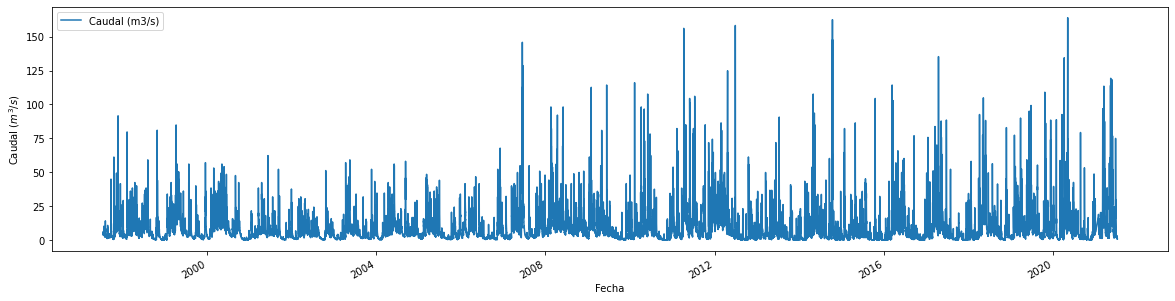

In [33]:
fig, ax = plt.subplots(figsize=(20,5))
# Assuming dataset is a pandas DataFrame with labeled columns
df_caudal.plot(ax=ax)
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
plt.ylabel('Caudal ($m^3/s$)')
# Adjusting the position of the legend
plt.legend()
plt.show()


## Unir los datos de precipitación (pluviómetros+satelitales) y caudal de la cuenca

In [34]:
df_pcp_1_daily = df_pcp_1.resample('D',label='right',closed='right').sum() 
df_pcp_2_daily = df_pcp_2.resample('D',label='right',closed='right').sum() 
df_pcp_3_daily = df_pcp_3.resample('D',label='right',closed='right').sum() 
df_caudal_daily = df_caudal.resample('D',label='right',closed='right').mean() 
all_data_daily = pd.concat([df_pcp_1_daily, df_pcp_2_daily, df_pcp_3_daily, precipitation_satellite, df_caudal_daily], axis=1)
all_data_daily

,Pluviómetro_1,Pluviómetro_2,Pluviómetro_3,1,2,3,6,7,8,9,...,22,23,24,25,26,27,28,31,32,Caudal (m3/s)
1997-07-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.800354
1997-07-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.510110
1997-07-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.573900
1997-07-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.166181
1997-07-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.233679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-29,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-30,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-01,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-02,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Determinar periodos con datos concurrentes

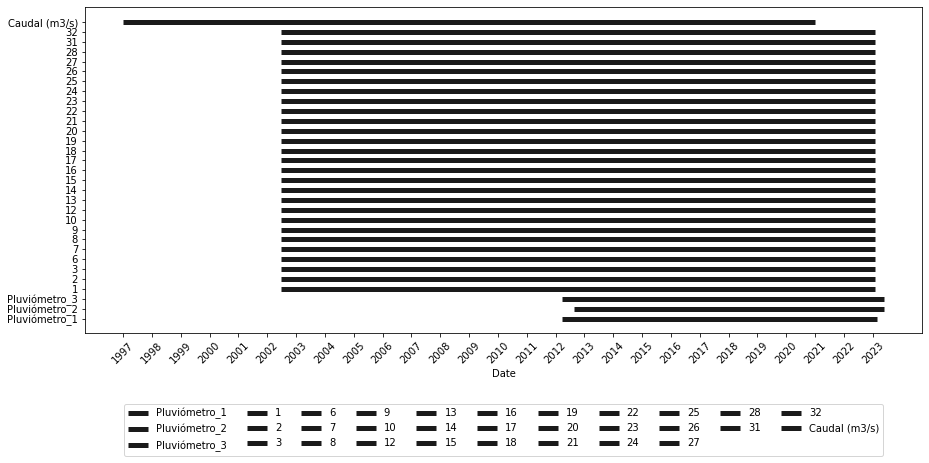

In [35]:
concurrent_periods = all_data_daily.dropna().index

# Create a figure and axis
fig, ax = plt.subplots(figsize=(15, 6))

# Loop through columns
for i, col in enumerate(all_data_daily.columns):
    # Get a boolean mask where data is not NaN for the current column
    mask = ~all_data_daily[col].isna()
    
    # Get the indices of True values in the mask
    indices = np.where(mask)[0]
    
    # Plot horizontal lines for continuity
    ax.hlines(i, indices[0], indices[-1], colors='0.1', linewidth=5, label=col)

# Set y-ticks and labels
ax.set_yticks(range(len(all_data_daily.columns)))
ax.set_yticklabels(all_data_daily.columns)

# Set x-axis label
ax.set_xlabel('Date')

# Set the x-axis ticks to show years
years = pd.to_datetime(all_data_daily.index).year
unique_years = np.unique(years)
ax.set_xticks(np.arange(len(all_data_daily.index), step=365))
ax.set_xticklabels(unique_years,rotation=45)

# Add legend
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=11)

# Show the plot
plt.show()




## Dividir datos en periodos de entrenamiento y prueba

In [36]:
all_data_daily = all_data_daily[~(all_data_daily.isna().any(axis=1) | (all_data_daily.lt(0).any(axis=1)))]
input_data_train = np.array(all_data_daily['2013':'2019'].iloc[:,:-1])
input_data_test = np.array(all_data_daily['2020':'2021-06'].iloc[:,:-1])

In [37]:
input_data_train

array([[ 0.     ,  0.     ,  0.43592, ..., 11.71   , 22.55   , 35.11   ],
       [ 0.10182,  0.     ,  0.     , ...,  0.     ,  0.     ,  0.     ],
       [ 1.93458,  0.     ,  1.19878, ...,  0.     ,  0.     ,  0.     ],
       ...,
       [ 2.0434 ,  5.166  ,  5.91354, ...,  0.     ,  0.     ,  0.     ],
       [ 1.53255,  2.583  ,  1.42363, ...,  0.     ,  0.     ,  0.     ],
       [12.56691,  7.12908,  8.32276, ...,  0.     ,  0.     ,  0.     ]])

In [39]:
output_data_train = np.reshape(np.array(all_data_daily['2013':'2019'].iloc[:,-1]),(all_data_daily['2013':'2019'].shape[0],1))
output_data_test = np.reshape(np.array(all_data_daily['2020':'2021-06'].iloc[:,-1]),(all_data_daily['2020':'2021-06'].shape[0],1))

In [40]:
output_data_train

array([[2.96700659],
       [2.27980975],
       [1.97144912],
       ...,
       [1.45913546],
       [2.10672294],
       [3.40283158]])

In [41]:
input_data_train_lags, output_data_train_lags= lagged_dataset(input_data_train, 3, output_data_train,15)

In [51]:
input_data_train_lags

array([[ 2.24004   ,  2.74775   ,  4.14124   , ...,  8.77239215,
         8.97135785,  6.01503537],
       [ 3.86916   ,  9.78199   , 11.22494   , ...,  8.97135785,
         6.01503537,  5.76108384],
       [ 0.        ,  0.        ,  0.        , ...,  6.01503537,
         5.76108384,  6.28283754],
       ...,
       [ 1.12387   ,  0.30996   ,  0.65706   , ...,  1.66572182,
         1.48337555,  1.68993365],
       [ 1.22604   ,  0.5166    ,  0.76657   , ...,  1.48337555,
         1.68993365,  1.45913546],
       [ 1.32821   ,  2.89296   ,  4.48991   , ...,  1.68993365,
         1.45913546,  2.10672294]])

In [52]:
output_data_train_lags

array([[5.76108384],
       [6.28283754],
       [8.81112158],
       ...,
       [1.45913546],
       [2.10672294],
       [3.40283158]])

In [53]:
input_data_test_lags, output_data_test_lags= lagged_dataset(input_data_test, 3, output_data_test,15)

In [48]:
input_data_test_lags

array([[ 0.2149266 ,  0.10332   ,  0.        , ..., 11.6085901 ,
         5.40761042,  4.09615773],
       [ 0.8597064 ,  1.44648   ,  4.3804    , ...,  5.40761042,
         4.09615773,  3.26299964],
       [ 0.2149266 ,  2.0664    ,  6.24207   , ...,  4.09615773,
         3.26299964,  2.38323539],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  5.4826092 ,
         4.08104159,  3.43069775],
       [ 0.84336   ,  1.641795  ,  1.11362   , ...,  4.08104159,
         3.43069775,  2.81574878],
       [ 0.5271    ,  3.830855  ,  4.009032  , ...,  3.43069775,
         2.81574878,  2.05206994]])

In [54]:
output_data_test_lags

array([[3.26299964e+00],
       [2.38323539e+00],
       [2.04150960e+00],
       [2.12740993e+00],
       [1.97586372e+00],
       [1.56266220e+00],
       [1.32490767e+00],
       [9.13074435e-01],
       [7.42564058e-01],
       [7.29255890e-01],
       [7.38267416e-01],
       [7.52041606e-01],
       [5.78568778e-01],
       [4.32383611e-01],
       [4.39384755e-01],
       [4.00086486e-01],
       [3.26506799e-01],
       [2.92573230e-01],
       [2.74681703e-01],
       [2.75181926e-01],
       [3.07345269e-01],
       [3.52692385e-01],
       [3.30488928e-01],
       [5.53051936e-01],
       [2.19522790e+00],
       [3.08987012e+00],
       [2.11562740e+00],
       [6.28034282e+00],
       [2.09868030e+01],
       [8.33435695e+00],
       [3.53802989e+00],
       [2.64702828e+00],
       [2.64398203e+00],
       [4.18060501e+00],
       [2.60989310e+00],
       [2.43471332e+00],
       [3.64091264e+00],
       [4.19450282e+00],
       [1.06584314e+01],
       [5.44914454e+00],


## Creación y entrenamiento de un modelo de Random Forest (no pronóstico)

### Definir hiperparámetros del modelo

In [55]:
min_samples_splt=10
min_samples_lf=4
max_dpth=350
n_trees=600
max_ft='sqrt'                                             

### Definir el modelo

In [56]:
regr=RandomForestRegressor(bootstrap=True,min_samples_split=min_samples_splt,
                               max_depth=max_dpth,max_features=max_ft,
                               min_samples_leaf=min_samples_lf,
                               n_estimators=n_trees,oob_score=True,n_jobs=-1,
                               warm_start=True,random_state=22)

### Entrenar el modelo

In [58]:
regr=regr.fit(input_data_train_lags, output_data_train_lags)


/Users/paul/opt/anaconda3/envs/INAMHI_forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.
/Users/paul/opt/anaconda3/envs/INAMHI_forecasting/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "


### Generar simulaciones para el periodo de entrenamiento

In [59]:
simulations_data_train= regr.predict(input_data_train_lags)
simulations_data_train= np.reshape(simulations_data_train, (-1, 1))
simulations_data_train

array([[ 7.12310116],
       [ 9.355741  ],
       [11.41534582],
       ...,
       [ 2.40537626],
       [ 2.75657206],
       [ 4.8742846 ]])

### Generar simulaciones para el periodo de prueba


In [60]:
#Prediction on unseen data
simulations_data_test= regr.predict(input_data_test_lags)
simulations_data_test= np.reshape(simulations_data_test, (-1, 1))
simulations_data_test

array([[ 6.75288725],
       [ 4.74747231],
       [ 4.19623461],
       [ 4.26767554],
       [ 3.41426957],
       [ 2.75556148],
       [ 2.46266109],
       [ 1.5146696 ],
       [ 1.29761584],
       [ 1.20919345],
       [ 1.97545136],
       [ 1.71797967],
       [ 1.06013705],
       [ 0.66530828],
       [ 0.48686282],
       [ 0.48872241],
       [ 0.42598054],
       [ 0.3608363 ],
       [ 0.29283161],
       [ 0.24364193],
       [ 0.30614404],
       [ 0.85188821],
       [ 1.12345121],
       [ 3.05103182],
       [ 3.52879817],
       [ 2.6384235 ],
       [ 3.49268985],
       [ 6.29483125],
       [ 8.11743596],
       [ 9.24776604],
       [ 6.77301464],
       [ 6.1613678 ],
       [ 5.11037072],
       [ 4.20988116],
       [ 2.83912022],
       [ 2.79816572],
       [ 3.38901612],
       [ 5.30629262],
       [ 7.71907067],
       [ 8.83598373],
       [ 6.14305933],
       [ 8.19315846],
       [ 8.45820994],
       [11.42233204],
       [14.52044847],
       [10

### Evaluación del modelo


Calcular los coeficientes de correlación de los periodos de entrenamiento y de prueba

In [61]:
r2_test=regr.score(input_data_test_lags, output_data_test_lags)
r2_train=regr.score(input_data_train_lags, output_data_train_lags)
print(r2_train,r2_test)

0.8964490465939476 0.7025000485202041


## Creación y entrenamiento de un modelo de Random Forest (pronóstico)

### Caso de pronóstico de 1 día

In [65]:
ventana_pronostico = 1
input_data_train_lags, output_data_train_lags= lagged_dataset_pron(input_data_train, 7, output_data_train,15, lead_time=ventana_pronostico)
input_data_test_lags, output_data_test_lags= lagged_dataset_pron(input_data_test, 7, output_data_test,15, lead_time=ventana_pronostico)
min_samples_splt=10
min_samples_lf=4
max_dpth=350
n_trees=600
max_ft='sqrt'                                             
regr=RandomForestRegressor(bootstrap=True,min_samples_split=min_samples_splt,
                               max_depth=max_dpth,max_features=max_ft,
                               min_samples_leaf=min_samples_lf,
                               n_estimators=n_trees,oob_score=True,n_jobs=-1,
                               warm_start=True,random_state=42)
regr=regr.fit(input_data_train_lags, output_data_train_lags)
#Prediction on training data
simulations_data_train= regr.predict(input_data_train_lags)
simulations_data_train= np.reshape(simulations_data_train, (-1, 1))
#Prediction on unseen data
simulations_data_test= regr.predict(input_data_test_lags)
simulations_data_test= np.reshape(simulations_data_test, (-1, 1))
r2_test=regr.score(input_data_test_lags, output_data_test_lags)
r2_train=regr.score(input_data_train_lags, output_data_train_lags)
print(r2_train,r2_test)

/Users/paul/opt/anaconda3/envs/INAMHI_forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.8341309148269611 0.5757348892552832


Los pronósticos en el periodo de prueba

In [66]:
simulations_data_test

array([[ 6.12739196],
       [ 5.1148923 ],
       [ 6.10401303],
       [ 4.74213477],
       [ 3.86471666],
       [ 4.10104077],
       [ 2.2583095 ],
       [ 2.10037667],
       [ 1.52879759],
       [ 2.04816644],
       [ 2.58437477],
       [ 1.57802508],
       [ 1.03656726],
       [ 0.66904184],
       [ 0.65983585],
       [ 0.56719851],
       [ 0.46411662],
       [ 0.38883202],
       [ 0.32350066],
       [ 0.27614204],
       [ 1.04590457],
       [ 1.5614992 ],
       [ 1.35975901],
       [ 3.78653152],
       [ 3.24838285],
       [ 3.90207203],
       [ 4.19232466],
       [ 9.60461772],
       [10.65582352],
       [ 8.08327961],
       [ 8.36773771],
       [ 5.56434438],
       [ 5.68651657],
       [ 3.86402708],
       [ 3.46494116],
       [ 3.55649136],
       [ 4.64795232],
       [ 7.85578778],
       [10.3191798 ],
       [ 5.91800701],
       [ 7.84378321],
       [10.70322035],
       [ 7.83529386],
       [16.00135058],
       [13.06622938],
       [ 8

### Evaluación usando una combinación de métricas de eficiencia

In [67]:
kge, rmse, pbias , r2 = calculate_hydro_metrics(simulations_data_test, output_data_test_lags)
print(f"RMSE: {rmse[0]:.4f}")
print(f"PBias: {pbias[0]:.4f}")
print(f"KGE: {kge[0]:.4f}")
print(f"R2: {r2:.4f}")

RMSE: 7.2489
PBias: 7.8763
KGE: 0.4957
R2: 0.5757


### Evaluación a través de inspección visual

Pronósticos de caudal 1 día

In [68]:
simulations_data_test = pd.DataFrame(simulations_data_test, columns=['Pronósticos'], index=all_data_daily['2019':'2021-06'].index[-len(simulations_data_test):])
simulations_data_test

,Pronósticos
2020-02-01,6.127392
2020-02-02,5.114892
2020-02-03,6.104013
2020-02-04,4.742135
2020-02-05,3.864717
...,...
2021-06-26,5.486117
2021-06-27,5.411874
2021-06-28,5.695916
2021-06-29,4.084510


Y las observaciones de caudal

In [69]:
observations_data_test = pd.DataFrame(output_data_test_lags, columns=['Observaciones'], index=all_data_daily['2019':'2021-06'].index[-len(output_data_test_lags):])
observations_data_test

,Observaciones
2020-02-01,2.383235
2020-02-02,2.041510
2020-02-03,2.127410
2020-02-04,1.975864
2020-02-05,1.562662
...,...
2021-06-26,4.081042
2021-06-27,3.430698
2021-06-28,2.815749
2021-06-29,2.052070


Juntar pronósticos y observaciones en un dataframe

In [70]:
testing_period = pd.concat([simulations_data_test, observations_data_test], axis=1)

In [71]:
testing_period

,Pronósticos,Observaciones
2020-02-01,6.127392,2.383235
2020-02-02,5.114892,2.041510
2020-02-03,6.104013,2.127410
2020-02-04,4.742135,1.975864
2020-02-05,3.864717,1.562662
...,...,...
2021-06-26,5.486117,4.081042
2021-06-27,5.411874,3.430698
2021-06-28,5.695916,2.815749
2021-06-29,4.084510,2.052070


Graficar (comparar) pronósticos y observaciones

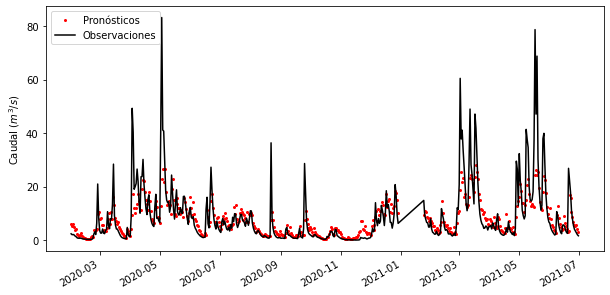

In [73]:
fig, ax= plt.subplots(figsize=(10, 5))

# Assuming testing_period is a pandas DataFrame with labeled columns
testing_period['Pronósticos'].plot(color='red', marker='o', linestyle='', markersize=2)
testing_period['Observaciones'].plot( color='black', linestyle='-')
# Adding labels for the legend
plt.legend(title='Legend Title')

# Adding a label to the y-axis
plt.ylabel('Caudal ($m^3/s$)')

# Adjusting the position of the legend
plt.legend()

plt.show()

Gráfico de dispersión entre pronósticos y observaciones

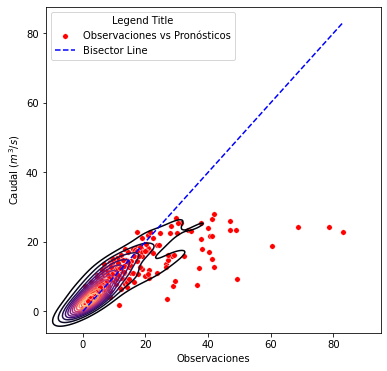

In [74]:

# Assuming testing_period is a pandas DataFrame with labeled columns
fig, ax = plt.subplots(figsize=(6, 6))
# Scatter plot for Observaciones
x = testing_period['Observaciones']
y = testing_period['Pronósticos']
sns.scatterplot(x=x, y=y, color='red', marker='o', s=30, label='Observaciones vs Pronósticos', ax=ax)
# KDE plot for density
# Assuming x and y are your data arrays
# Concatenate x and y into a single array
data = np.vstack((x, y)).T
sns.kdeplot(x=x,y=y,cmap='magma', ax=ax, fill=False, thresh=0, levels=13, legend=False)
# Add a bisector line (y = x)
min_val = min(x.min(), y.min())
max_val = max(x.max(), y.max())
ax.plot([min_val, max_val], [min_val, max_val], color='blue', linestyle='--', label='Bisector Line')
# Adding labels for the legend
ax.legend(title='Legend Title')
# Adding a label to the y-axis
ax.set_ylabel('Caudal ($m^3/s$)')
# Show the plot
plt.show()



## Incluir datos ENSO


https://psl.noaa.gov/gcos_wgsp/Timeseries/

Importar datos de El Niño

In [75]:
# Define the path to 
folder_nino12 = folder+'ENSO/nino12.long.anom.data.xlsx'
folder_nino3 = folder+'ENSO/nino3.long.anom.data.xlsx'
folder_nino34 = folder+'ENSO/nino34.long.anom.data.xlsx'


In [76]:
# Use tabula to extract tables
nino12 =  pd.read_excel(folder_nino12)
nino3 =  pd.read_excel(folder_nino3)
nino34 =  pd.read_excel(folder_nino34)

In [77]:
# Melt the DataFrame to convert it to long format
nino12_long = nino12.melt(id_vars=['Year'], var_name='Month', value_name='Data')
# Replace '-99.99' values with NaN
nino12_long['Data'] = nino12_long['Data'].replace(-99.99, np.nan)
# Convert 'Year' and 'Month' to datetime format
nino12_long['Date'] = pd.to_datetime(nino12_long['Year'].astype(str) + '-' + nino12_long['Month'], format='%Y-%B')
# Set 'Date' as the index
nino12_time_series = nino12_long.set_index('Date')[['Data']]
# Display the resulting DataFrame
nino12_time_series

# Melt the DataFrame to convert it to long format
nino3_long = nino3.melt(id_vars=['Year'], var_name='Month', value_name='Data')
# Replace '-99.99' values with NaN
nino3_long['Data'] = nino3_long['Data'].replace(-99.99, np.nan)
# Convert 'Year' and 'Month' to datetime format
nino3_long['Date'] = pd.to_datetime(nino3_long['Year'].astype(str) + '-' + nino3_long['Month'], format='%Y-%B')
# Set 'Date' as the index
nino3_time_series = nino3_long.set_index('Date')[['Data']]
# Display the resulting DataFrame
nino3_time_series

# Melt the DataFrame to convert it to long format
nino34_long = nino34.melt(id_vars=['Year'], var_name='Month', value_name='Data')
# Replace '-99.99' values with NaN
nino34_long['Data'] = nino34_long['Data'].replace(-99.99, np.nan)
# Convert 'Year' and 'Month' to datetime format
nino34_long['Date'] = pd.to_datetime(nino34_long['Year'].astype(str) + '-' + nino34_long['Month'], format='%Y-%B')
# Set 'Date' as the index
nino34_time_series = nino34_long.set_index('Date')[['Data']]
# Display the resulting DataFrame
nino34_time_series

,Data
Date,
1870-01-01,-1.00
1871-01-01,-0.25
1872-01-01,-0.72
1873-01-01,-0.78
1874-01-01,-0.93
...,...
2019-12-01,0.51
2020-12-01,-0.98
2021-12-01,-1.07


Pasar de datos mensuales a diarios

In [78]:
nino12_df = nino12_time_series.resample('D').ffill()
nino3_df = nino3_time_series.resample('D').ffill()
nino34_df = nino34_time_series.resample('D').ffill()

In [79]:
ENSO_daily = pd.concat([nino12_df,nino3_df,nino34_df], axis=1)
ENSO_daily

,Data,Data,Data
Date,,,
1870-01-01,-1.5,-1.35,-1.0
1870-01-02,-1.5,-1.35,-1.0
1870-01-03,-1.5,-1.35,-1.0
1870-01-04,-1.5,-1.35,-1.0
1870-01-05,-1.5,-1.35,-1.0
...,...,...,...
2023-11-27,NaN,NaN,NaN
2023-11-28,NaN,NaN,NaN
2023-11-29,NaN,NaN,NaN


Juntar toda la información

In [80]:
all_data_daily_ENSO = pd.concat([all_data_daily, ENSO_daily], axis=1)
all_data_daily_ENSO

,Pluviómetro_1,Pluviómetro_2,Pluviómetro_3,1,2,3,6,7,8,9,...,25,26,27,28,31,32,Caudal (m3/s),Data,Data,Data
1870-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.5,-1.35,-1.0
1870-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.5,-1.35,-1.0
1870-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.5,-1.35,-1.0
1870-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.5,-1.35,-1.0
1870-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.5,-1.35,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
all_data_daily_ENSO['2013']

/Users/paul/opt/anaconda3/envs/INAMHI_forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """Entry point for launching an IPython kernel.


,Pluviómetro_1,Pluviómetro_2,Pluviómetro_3,1,2,3,6,7,8,9,...,25,26,27,28,31,32,Caudal (m3/s),Data,Data,Data
2013-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.70,-0.59,-0.42
2013-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.70,-0.59,-0.42
2013-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.70,-0.59,-0.42
2013-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.70,-0.59,-0.42
2013-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.70,-0.59,-0.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-27,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.215175,-0.25,-0.02,-0.09
2013-12-28,0.40728,0.43964,0.98082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.150495,-0.25,-0.02,-0.09
2013-12-29,0.61092,0.21982,0.21796,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.128070,-0.25,-0.02,-0.09
2013-12-30,2.44368,2.30811,2.28858,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.125228,-0.25,-0.02,-0.09


Definir periodos de entrenamiento y prueba

In [83]:
all_data_daily_ENSO = all_data_daily_ENSO[~(all_data_daily_ENSO.isna().any(axis=1))]
all_data_daily_ENSO.shape
inputs = all_data_daily_ENSO.drop(all_data_daily_ENSO.columns[-4], axis=1)
input_data_train = np.array(inputs['2013':'2019'].iloc[:,:-1])
input_data_test = np.array(inputs['2020':'2021-06'].iloc[:,:-1])
output_data_train = np.reshape(np.array(all_data_daily_ENSO['2013':'2019'].iloc[:,-4]),(all_data_daily_ENSO['2013':'2019'].shape[0],1))
output_data_test = np.reshape(np.array(all_data_daily_ENSO['2020':'2021-06'].iloc[:,-4]),(all_data_daily_ENSO['2020':'2021-06'].shape[0],1))

In [84]:
input_data_train

array([[ 0.     ,  0.     ,  0.43592, ..., 35.11   , -0.38   ,  0.04   ],
       [ 0.10182,  0.     ,  0.     , ...,  0.     , -0.38   ,  0.04   ],
       [ 1.93458,  0.     ,  1.19878, ...,  0.     , -0.38   ,  0.04   ],
       ...,
       [ 2.0434 ,  5.166  ,  5.91354, ...,  0.     , -0.19   ,  0.25   ],
       [ 1.53255,  2.583  ,  1.42363, ...,  0.     , -0.19   ,  0.25   ],
       [12.56691,  7.12908,  8.32276, ...,  0.     , -0.19   ,  0.25   ]])

In [85]:
output_data_test

array([[1.53248767e+01],
       [1.58211567e+01],
       [1.42347386e+01],
       [1.26846169e+01],
       [6.87607984e+00],
       [4.76350963e+00],
       [4.18824255e+00],
       [3.38542495e+00],
       [4.93260764e+00],
       [4.85179543e+00],
       [1.79362249e+01],
       [2.34326570e+01],
       [1.16085901e+01],
       [5.40761042e+00],
       [4.09615773e+00],
       [3.26299964e+00],
       [2.38323539e+00],
       [2.04150960e+00],
       [2.12740993e+00],
       [1.97586372e+00],
       [1.56266220e+00],
       [1.32490767e+00],
       [9.13074435e-01],
       [7.42564058e-01],
       [7.29255890e-01],
       [7.38267416e-01],
       [7.52041606e-01],
       [5.78568778e-01],
       [4.32383611e-01],
       [4.39384755e-01],
       [4.00086486e-01],
       [3.26506799e-01],
       [2.92573230e-01],
       [2.74681703e-01],
       [2.75181926e-01],
       [3.07345269e-01],
       [3.52692385e-01],
       [3.30488928e-01],
       [5.53051936e-01],
       [2.19522790e+00],


Desarrollo de modelos de pronóstico a 1 día

In [86]:
ventana_pronostico = 1
input_data_train_lags, output_data_train_lags= lagged_dataset_pron(input_data_train, 3, output_data_train,15, lead_time=ventana_pronostico)
input_data_test_lags, output_data_test_lags= lagged_dataset_pron(input_data_test, 3, output_data_test,15, lead_time=ventana_pronostico)
min_samples_splt=10
min_samples_lf=4
max_dpth=350
n_trees=600
max_ft='sqrt'                                             
regr=RandomForestRegressor(bootstrap=True,min_samples_split=min_samples_splt,
                               max_depth=max_dpth,max_features=max_ft,
                               min_samples_leaf=min_samples_lf,
                               n_estimators=n_trees,oob_score=True,n_jobs=-1,
                               warm_start=True,random_state=22)
regr=regr.fit(input_data_train_lags, output_data_train_lags)
#Prediction on training data
simulations_data_train_ENSO= regr.predict(input_data_train_lags)
simulations_data_train_ENSO= np.reshape(simulations_data_train_ENSO, (-1, 1))
#Prediction on unseen data
simulations_data_test_ENSO= regr.predict(input_data_test_lags)
simulations_data_test_ENSO= np.reshape(simulations_data_test_ENSO, (-1, 1))
r2_test=regr.score(input_data_test_lags, output_data_test_lags)
r2_train=regr.score(input_data_train_lags, output_data_train_lags)
print(r2_train,r2_test)

/Users/paul/opt/anaconda3/envs/INAMHI_forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.8474873386767902 0.6160416132048145


### Evaluación con métricas de eficiencia

In [87]:
kge, rmse, pbias , r2 = calculate_hydro_metrics(simulations_data_test_ENSO, output_data_test_lags)
print(f"RMSE: {rmse[0]:.4f}")
print(f"PBias: {pbias[0]:.4f}")
print(f"KGE: {kge[0]:.4f}")
print(f"R2: {r2:.4f}")

RMSE: 6.8960
PBias: 7.3496
KGE: 0.5422
R2: 0.6160


### Inspección visual

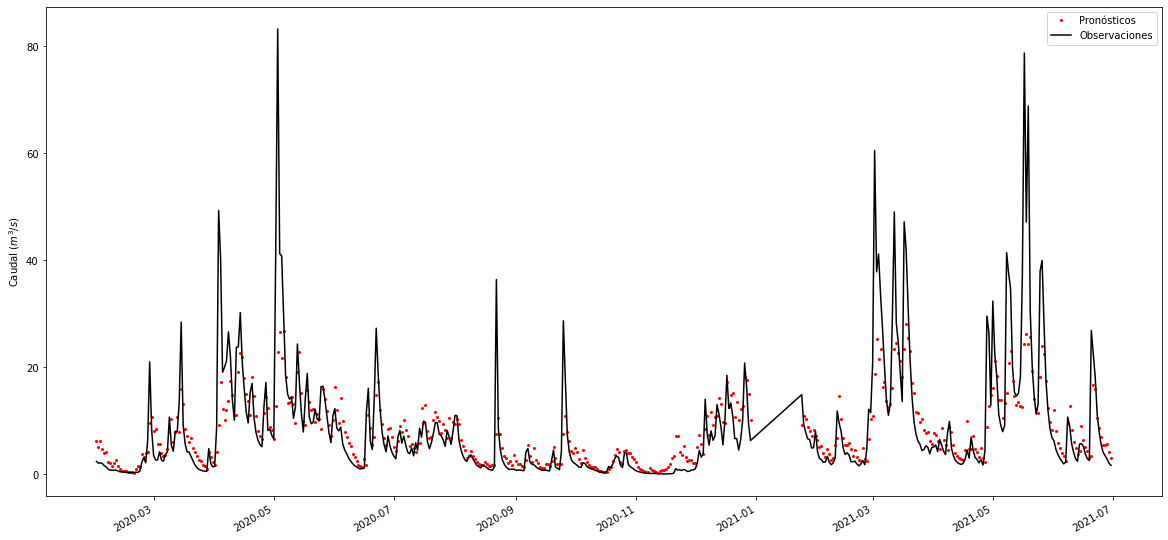

In [88]:
simulations_data_test_ENSO = pd.DataFrame(simulations_data_test, columns=['Pronósticos'], index=all_data_daily['2019':'2021-06'].index[-len(simulations_data_test):])
observations_data_test_ENSO = pd.DataFrame(output_data_test_lags, columns=['Observaciones'], index=all_data_daily['2019':'2021-06'].index[-len(output_data_test_lags):])
testing_period_ENSO = pd.concat([simulations_data_test_ENSO, observations_data_test_ENSO], axis=1)
fig, ax= plt.subplots(figsize=(20, 10))

# Assuming testing_period is a pandas DataFrame with labeled columns
testing_period_ENSO['Pronósticos'].plot(color='red', marker='o', linestyle='', markersize=2)
testing_period_ENSO['Observaciones'].plot( color='black', linestyle='-')

# Adding labels for the legend
plt.legend(title='Legend Title')

# Adding a label to the y-axis
plt.ylabel('Caudal ($m^3/s$)')

# Adjusting the position of the legend
plt.legend()
plt.show()

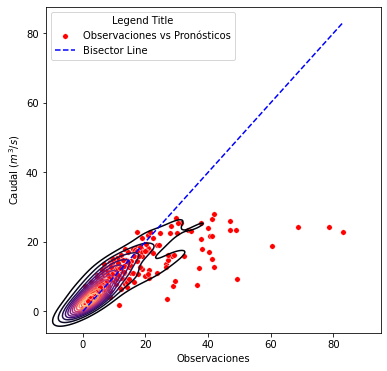

In [89]:

# Assuming testing_period is a pandas DataFrame with labeled columns
fig, ax = plt.subplots(figsize=(6, 6))

# Scatter plot for Observaciones
x = testing_period_ENSO['Observaciones']
y = testing_period_ENSO['Pronósticos']
sns.scatterplot(x=x, y=y, color='red', marker='o', s=30, label='Observaciones vs Pronósticos', ax=ax)

# KDE plot for density


data = np.vstack((x, y)).T

sns.kdeplot(x=x, y=y, cmap='magma', ax=ax, fill=False, thresh=0, levels=13, legend=False)

# Add a bisector line (y = x)
min_val = min(x.min(), y.min())
max_val = max(x.max(), y.max())
ax.plot([min_val, max_val], [min_val, max_val], color='blue', linestyle='--', label='Bisector Line')

# Adding labels for the legend
ax.legend(title='Legend Title')

# Adding a label to the y-axis
ax.set_ylabel('Caudal ($m^3/s$)')

# Show the plot
plt.show()


## Hiperparametrización del modelo de pronóstico

Definir dominio de búsqueda de hiperparámetros

In [90]:
# Define the parameter grid
param_grid = {
    'min_samples_split': [ 10, 20],
    'min_samples_leaf': [2, 10],
    'max_depth': [100, 300],
    'n_estimators': [300, 500],
    'max_features': ['sqrt','log2']
}

# Calculate the total number of combinations
total_combinations = len(list(itertools.product(*param_grid.values())))

total_combinations

32

Búsqueda de mejor combinación de hiperparámetros

In [91]:
# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=RandomForestRegressor(oob_score=True, n_jobs=-1, warm_start=True),
                           param_grid=param_grid, cv=3, n_jobs=-1, scoring='r2')

# Fit the GridSearchCV to your data
grid_search.fit(input_data_train_lags, output_data_train_lags)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_params)


/Users/paul/opt/anaconda3/envs/INAMHI_forecasting/lib/python3.7/site-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Best Hyperparameters:
{'max_depth': 300, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}


Una hiperparametrización más rigurosa

In [92]:
# Define the parameter grid
param_grid = {
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [2, 4, 8],
    'max_depth': [100, 200, 350],
    'n_estimators': [200, 300, 400, 500, 600],
    'max_features': ['auto', 'sqrt','log2']
}
# Calculate the total number of combinations
total_combinations = len(list(itertools.product(*param_grid.values())))

total_combinations
# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=RandomForestRegressor(oob_score=True, n_jobs=-1, warm_start=True),
                           param_grid=param_grid, cv=3, n_jobs=-1, scoring='r2')

# Fit the GridSearchCV to your data
grid_search.fit(input_data_train_lags, output_data_train_lags)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_params)

KeyboardInterrupt: 

In [93]:
best_model
simulations_data_train_ENSO= best_model.predict(input_data_train_lags)
simulations_data_train_ENSO= np.reshape(simulations_data_train_ENSO, (-1, 1))
#Prediction on unseen data
simulations_data_test_ENSO= best_model.predict(input_data_test_lags)
simulations_data_test_ENSO= np.reshape(simulations_data_test_ENSO, (-1, 1))
#Nash_Sutcliffe    
r2_test=regr.score(input_data_test_lags, output_data_test_lags)
r2_train=regr.score(input_data_train_lags, output_data_train_lags)
print(r2_train,r2_test)

0.8474873386767902 0.6160416132048145


In [160]:
best_model


RandomForestRegressor(max_depth=300, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=10, n_estimators=300, n_jobs=-1,
                      oob_score=True, warm_start=True)

In [94]:
ventana_pronostico = 1
input_data_train_lags, output_data_train_lags= lagged_dataset_pron(input_data_train, 3, output_data_train,15, lead_time=ventana_pronostico)
input_data_test_lags, output_data_test_lags= lagged_dataset_pron(input_data_test, 3, output_data_test,15, lead_time=ventana_pronostico)
min_samples_splt=10
min_samples_lf=2
max_dpth=300
n_trees=300
max_ft='sqrt'                                             
regr=RandomForestRegressor(bootstrap=True,min_samples_split=min_samples_splt,
                               max_depth=max_dpth,max_features=max_ft,
                               min_samples_leaf=min_samples_lf,
                               n_estimators=n_trees,oob_score=True,n_jobs=-1,
                               warm_start=True,random_state=22)
regr=regr.fit(input_data_train_lags, output_data_train_lags)
#Prediction on training data
simulations_data_train_ENSO= regr.predict(input_data_train_lags)
simulations_data_train_ENSO= np.reshape(simulations_data_train_ENSO, (-1, 1))
#Prediction on unseen data
simulations_data_test_ENSO= regr.predict(input_data_test_lags)
simulations_data_test_ENSO= np.reshape(simulations_data_test_ENSO, (-1, 1))
r2_test=regr.score(input_data_test_lags, output_data_test_lags)
r2_train=regr.score(input_data_train_lags, output_data_train_lags)
print(r2_train,r2_test)
kge, rmse, pbias , r2 = calculate_hydro_metrics(simulations_data_test_ENSO, output_data_test_lags)
print(f"RMSE: {rmse[0]:.4f}")
print(f"PBias: {pbias[0]:.4f}")
print(f"KGE: {kge[0]:.4f}")
print(f"R2: {r2:.4f}")

/Users/paul/opt/anaconda3/envs/INAMHI_forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.8696540006316625 0.6234058267474065
RMSE: 6.8295
PBias: 6.1895
KGE: 0.5572
R2: 0.6234
